In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import  numpy as np
from itertools import product


import pickle
import numpy as np
import os

import plotly.express as px

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection
import networkx as nx
from scipy.spatial import distance
from sklearn.cluster import KMeans

import warnings

#import gaussian filter 1d

from scipy.ndimage import gaussian_filter1d
import pandas as pd

pd.options.mode.chained_assignment = None  # Suppresses chained assignment warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Data processing

## Utils function

In [3]:
def extractDf(dfPlotTrajectory, obstacle, view, haptics):
    dfplot = dfPlotTrajectory.query(f"Obs == '{obstacle}' & View == '{view}' & Haptics == '{haptics}'")[[ "Time", "meanPosX", "meanPosY", "meanPosZ", "desiredSeparation"]]
    return dfplot

def compute_network_path(kmeans, startClust, endClust):
    centers = kmeans.cluster_centers_
    G = nx.Graph()
    
    # Add each cluster center as a node in the graph.
    for i, c in enumerate(centers):
        G.add_node(i, pos=c)
    
    # Identify indices of the start and end clusters.
    start_index = np.where((centers == startClust).all(axis=1))[0][0]
    end_index   = np.where((centers == endClust).all(axis=1))[0][0]
    
    # For each cluster (except start and end), connect to its two closest clusters.
    for i, c in enumerate(centers):
        if i == start_index or i == end_index:
            continue  # Skip the start and end clusters.
        dists = distance.cdist([c], centers)[0]
        sorted_indices = np.argsort(dists)
        # The closest is itself (distance 0), so take the next two.
        for j in sorted_indices[1:3]:
            G.add_edge(i, j, weight=dists[j])
    
    # For the start cluster, add an edge to its nearest neighbor (ignoring itself).
    dists = distance.cdist([startClust], centers)[0]
    sorted_indices = np.argsort(dists)
    neighbor = sorted_indices[1]
    G.add_edge(start_index, neighbor, weight=dists[neighbor])
    
    # For the end cluster, add an edge to its nearest neighbor.
    dists = distance.cdist([endClust], centers)[0]
    sorted_indices = np.argsort(dists)
    neighbor = sorted_indices[1]
    G.add_edge(end_index, neighbor, weight=dists[neighbor])
    
    # Ensure connectivity: if the graph is not connected, iteratively add edges
    # connecting the separate components with the smallest possible distances.
    if not nx.is_connected(G):
        # Get the list of connected components.
        components = list(nx.connected_components(G))
        # Continue until we have a single connected graph.
        while len(components) > 1:
            best_edge = None
            best_weight = np.inf
            # Check pairs: one node from the first component and one node from any other.
            for i in components[0]:
                for comp in components[1:]:
                    for j in comp:
                        # Compute Euclidean distance between centers.
                        w = np.linalg.norm(centers[i] - centers[j])
                        if w < best_weight:
                            best_weight = w
                            best_edge = (i, j)
            # Add the best edge found to join two components.
            if best_edge is not None:
                G.add_edge(best_edge[0], best_edge[1], weight=best_weight)
            # Update the list of connected components.
            components = list(nx.connected_components(G))
    
    # Compute the shortest path from the start to end cluster.
    path_indices = nx.shortest_path(G, source=start_index, target=end_index, weight='weight')
    
    # Convert node indices back to coordinates.
    path_coords = [centers[i] for i in path_indices]
    return path_coords


def get_progress(x, y, path):
    """
    Compute a progress index (0 = start, 1 = end) for a given point (x, y) along a path.
    
    The path is assumed to be an ordered list of points (each as [x, y]). The function works by
    projecting the point onto each segment of the path and selecting the projection with the minimum distance.
    Then it calculates the cumulative distance from the start of the path to that projection and normalizes by
    the total path length.
    
    Parameters:
        x, y : Coordinates of the query point.
        path : Ordered list of points (each as [x, y]) defining the path from start to end.
    
    Returns:
        progress : A float between 0 (at the start) and 1 (at the end) indicating the point's relative position along the path.
    """
    P = np.array([x, y])
    
    # Compute cumulative distances along the path.
    cumulative = [0]
    total_length = 0
    for i in range(1, len(path)):
        seg_length = np.linalg.norm(np.array(path[i]) - np.array(path[i-1]))
        total_length += seg_length
        cumulative.append(total_length)
    
    # Project P onto each segment and find the closest projection.
    min_dist = float('inf')
    proj_length = None  # Distance along the path corresponding to the best projection.
    for i in range(1, len(path)):
        A = np.array(path[i-1])
        B = np.array(path[i])
        AB = B - A
        seg_len_sq = np.dot(AB, AB)
        if seg_len_sq == 0:  # Degenerate segment.
            continue
        t = np.dot(P - A, AB) / seg_len_sq
        t_clamped = np.clip(t, 0, 1)
        proj = A + t_clamped * AB  # Projection of P onto segment [A, B]
        d = np.linalg.norm(P - proj)
        if d < min_dist:
            min_dist = d
            seg_length = np.linalg.norm(AB)
            proj_length = cumulative[i-1] + t_clamped * seg_length

    if proj_length is None:
        return 0.0
    
    if proj_length > total_length:
        return 1.0
    
    
    progress = proj_length / total_length
    return progress

def defineProgress(dfPlotTraj, obstacle, view, haptics, path):

    dfplot = extractDf(dfPlotTraj, obstacle, view, haptics)
    dfplot.dropna(inplace=True)

    dfplot["progress"] = dfplot.apply(lambda row: get_progress(row["meanPosX"], row["meanPosZ"], path), axis=1)

    dfplot["progressBin"] = pd.cut(dfplot["progress"], bins=60)
    dfplot["meanPosXReal"] = dfplot["meanPosX"].astype(float)
    dfplot["meanPosYReal"] = dfplot["meanPosZ"].astype(float)

    dfplotFinal = dfplot.groupby("progressBin")[["meanPosXReal", "meanPosYReal"]].mean().reset_index()

    color = dfplot.groupby("progressBin")[["meanPosXReal"]].count().reset_index()
    color["meanPosXReal"] = (color["meanPosXReal"] - color["meanPosXReal"].min()) / (color["meanPosXReal"].nlargest(2).iloc[-1] - color["meanPosXReal"].min())
    color["meanPosXReal"] = color["meanPosXReal"].clip(0, 1)

    #make the color from green to red
    color["color"] = color["meanPosXReal"]

    dfplotFinal = dfplotFinal.merge(color[["progressBin", "color"]], on="progressBin")

    return dfplot, dfplotFinal
    

In [4]:
def violinGraphSituation(df, metric):
    grouped = df.groupby(["View", "Obstacle"])
    
    all_data = []
    positions = []
    x_labels = []
    colors = []
    pos_counter = 1
    scenario_separators = []

    prev_view_obstacle = None
    for (view, obstacle), subset in grouped:
        h_times = subset[subset["Haptics"] == "H"][metric].values
        nh_times = subset[subset["Haptics"] == "NH"][metric].values
        
        h_count = len(h_times)
        nh_count = len(nh_times)
        
        all_data.append(h_times)
        positions.append(pos_counter)
        x_labels.append(f"{view}-{obstacle}-H\n(n={h_count})")
        colors.append("red")
        pos_counter += 1

        all_data.append(nh_times)
        positions.append(pos_counter)
        x_labels.append(f"{view}-{obstacle}-NH\n(n={nh_count})")
        colors.append("blue")
        pos_counter += 1

        if prev_view_obstacle is not None and prev_view_obstacle != (view, obstacle):
            scenario_separators.append(pos_counter - 2)  # Adjust separator position
        prev_view_obstacle = (view, obstacle)
    
    plt.figure(figsize=(12, 6))
    violin_parts = plt.violinplot(dataset=all_data, positions=positions, showmeans=True)
    
    for i, pc in enumerate(violin_parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)

    for partname in ['cbars', 'cmins', 'cmaxes', 'cmeans']:
        vp = violin_parts[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(1)
    
    for sep in scenario_separators:
        plt.axvline(x=sep-0.5, color='black', linestyle='--', linewidth=1)
    
    plt.xticks(positions, x_labels, rotation=45, ha='right')
    plt.xlabel("View - Obstacle - Haptics")
    plt.ylabel(metric)
    plt.title(f"Violin Plot of {metric} by View, Obstacle, and Haptics (H=Red, NH=Blue)")
    plt.tight_layout()
    plt.show()

def boxPlotSituation(df, metric):
    grouped = df.groupby(["View", "Obstacle"])
    
    all_data = []
    positions = []
    x_labels = []
    colors = []
    pos_counter = 1
    scenario_separators = []
    
    prev_view_obstacle = None
    for (view, obstacle), subset in grouped:
        h_times = subset[subset["Haptics"] == "H"][metric].values
        nh_times = subset[subset["Haptics"] == "NH"][metric].values
        
        h_count = len(h_times)
        nh_count = len(nh_times)
        
        all_data.append(h_times)
        positions.append(pos_counter)
        x_labels.append(f"{view}-{obstacle}-H\n(n={h_count})")
        colors.append("red")
        pos_counter += 1
        
        all_data.append(nh_times)
        positions.append(pos_counter)
        x_labels.append(f"{view}-{obstacle}-NH\n(n={nh_count})")
        colors.append("blue")
        pos_counter += 1
        
        if prev_view_obstacle is not None and prev_view_obstacle != (view, obstacle):
            scenario_separators.append(pos_counter - 2)  # Adjust separator position
        prev_view_obstacle = (view, obstacle)
    
    plt.figure(figsize=(12, 6))
    box_parts = plt.boxplot(all_data, positions=positions, patch_artist=True, showmeans=True)
    
    for i, box in enumerate(box_parts['boxes']):
        box.set_facecolor(colors[i])
        box.set_edgecolor('black')
        box.set_alpha(0.7)
    
    for sep in scenario_separators:
        plt.axvline(x=sep - 0.5, color='black', linestyle='--', linewidth=1)
    
    plt.xticks(positions, x_labels, rotation=45, ha='right')
    plt.xlabel("View - Obstacle - Haptics")
    plt.ylabel(metric)
    plt.title(f"Box Plot of {metric} by View, Obstacle, and Haptics (H=Red, NH=Blue)")
    plt.tight_layout()
    plt.show()


In [5]:
def plot_path_analysis_speed(dfPlot, title):
    fig, axes = plt.subplots(1,5, figsize=(50, 10))
    
    # Scatter plot
    axes[0].plot(dfPlot["meanPosX"], dfPlot["meanPosZ"], 'ro', label="Haptic", markersize=0.5)
    axes[0].legend()
    axes[0].set_title("Scatter Plot")
    
    # Heatmap
    axes[1].hist2d(dfPlot["meanPosX"], dfPlot["meanPosZ"], bins=100)
    axes[1].set_title("Heatmap")
    
    # KMeans Clustering
    kmeans = KMeans(n_clusters=60, n_init=10)
    kmeans.fit(dfPlot[["meanPosX", "meanPosZ"]])
    
    axes[2].hist2d(dfPlot["meanPosX"], dfPlot["meanPosZ"], bins=100)
    axes[2].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='red')
    axes[2].set_title("KMeans Clustering")
    
    # Path Visualization
    dfPlot.dropna(inplace=True)

    
    startClust = dfPlot.iloc[0][["meanPosX", "meanPosZ"]].values.astype(float)
    endClust   = dfPlot.iloc[-1][["meanPosX", "meanPosZ"]].values.astype(float)

    print(startClust, "   ", endClust)

    print(distance.cdist([startClust], kmeans.cluster_centers_).argmin())

    startClust = kmeans.cluster_centers_[distance.cdist([startClust], kmeans.cluster_centers_).argmin()];
    endClust = kmeans.cluster_centers_[distance.cdist([endClust], kmeans.cluster_centers_).argmin()];
    
    path = compute_network_path(kmeans, startClust, endClust)


    
    for i in range(len(path) - 1):
        progress = get_progress(path[i][0], path[i][1], path)
        color = (1 - progress, progress, 0)
        axes[3].plot([path[i][0], path[i+1][0]], [path[i][1], path[i+1][1]], 'o-', color=color)
    
    axes[3].plot([startClust[0], endClust[0]], [startClust[1], endClust[1]], 'bo')
    axes[3].set_title("Path with Of Progression")

    axes[3].hist2d(dfPlot["meanPosX"], dfPlot["meanPosZ"], bins=100)


    dfplotFinal = dfPlot.groupby("progressBin")[["meanPosXReal", "meanPosYReal"]].mean().reset_index()


    color = dfPlot.groupby("progressBin")[["meanPosXReal"]].count().reset_index()
    color["meanPosXReal"] = (color["meanPosXReal"] - color["meanPosXReal"].min()) / (color["meanPosXReal"].nlargest(2).iloc[-1] - color["meanPosXReal"].min())
    color["meanPosXReal"] = color["meanPosXReal"].clip(0, 1)

    #make the color from green to red
    color["color"] = color["meanPosXReal"]


    dfplotFinal = dfplotFinal.merge(color[["progressBin", "color"]], on="progressBin")

    # Get the values from your DataFrame
    x = dfplotFinal["meanPosXReal"].values
    y = dfplotFinal["meanPosYReal"].values
    c = dfplotFinal["color"].values  # these should be values between 0 and 1

    # Create line segments from the x,y points.
    # Each segment is defined by two consecutive points.
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Compute an average color for each segment
    seg_colors = (c[:-1] + c[1:]) / 2

    # Create a LineCollection. The cmap 'viridis' will be used,
    # and the norm ensures the colormap spans from 0 to 1.
    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['green', 'red'])

    # Number of interpolation steps per segment (higher = smoother gradient)
    num_interp = 10  

    # Create interpolated segments and colors
    new_segments = []
    new_colors = []

    for i in range(len(x) - 1):
        # Linearly interpolate points along the segment
        interp_x = np.linspace(x[i], x[i+1], num_interp)
        interp_y = np.linspace(y[i], y[i+1], num_interp)
        
        # Linearly interpolate colors for smooth transition
        interp_c = np.linspace(c[i], c[i+1], num_interp)

        # Create the sub-segments
        for j in range(num_interp - 1):
            new_segments.append([[interp_x[j], interp_y[j]], [interp_x[j+1], interp_y[j+1]]])
            new_colors.append(interp_c[j])  # Assign color gradually along the segment

    # Convert to NumPy array for `LineCollection`
    new_segments = np.array(new_segments)

    # Create the LineCollection with the interpolated color map
    lc = LineCollection(new_segments, cmap=custom_cmap, norm=plt.Normalize(0, 1))
    lc.set_array(np.array(new_colors))
    lc.set_linewidth(2)

    # Plotting the gradient line
    axes[4].add_collection(lc)
    plt.colorbar(lc, ax=axes[4], label="Gradient Value")

    # Also plot the Haptic points
    axes[4].plot(dfPlot["meanPosX"], dfPlot["meanPosZ"], 'o', markersize=0.5, alpha=0.05, color='blue')

    axes[4].set_title("Gradient Line for speed")

    #STE THE main title

    fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.show()

def showPlot(index, dfTrajectory):
    title = f"Path Progression for {dfTrajectory.iloc[index]["Obstacle"]} - {dfTrajectory.iloc[index]["View"]} - {dfTrajectory.iloc[index]["Haptics"]}"
    plot_path_analysis_speed(dfTrajectory.iloc[index]["FlightState"], title)

def plot_path_analysis_spread(dfPlot, title):
    fig, axes = plt.subplots(1,1, figsize=(10, 10))

    dfplotFinal = dfPlot.groupby("progressBin")[["meanPosXReal", "meanPosYReal", "desiredSeparation"]].mean().reset_index()


    color = dfPlot.groupby("progressBin")[["desiredSeparation"]].mean().reset_index()
   # color["meanPosXReal"] = (color["desiredSeparation"] - color["desiredSeparation"].min()) / (color["desiredSeparation"].max() - color["desiredSeparation"].min())
    color["meanPosXReal"] = color["desiredSeparation"]
    #color["meanPosXReal"] = color["meanPosXReal"].clip(0, 1)

    #make the color from green to red
    color["color"] = color["meanPosXReal"]


    dfplotFinal = dfplotFinal.merge(color[["progressBin", "color"]], on="progressBin")

    # Get the values from your DataFrame
    x = dfplotFinal["meanPosXReal"].values
    y = dfplotFinal["meanPosYReal"].values
    c = dfplotFinal["color"].values  # these should be values between 0 and 1

    # Create line segments from the x,y points.
    # Each segment is defined by two consecutive points.
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    # Create a LineCollection. The cmap 'viridis' will be used,
    # and the norm ensures the colormap spans from 0 to 1.
    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['green', 'red'])

    # Number of interpolation steps per segment (higher = smoother gradient)
    num_interp = 10  

    # Create interpolated segments and colors
    new_segments = []
    new_colors = []

    for i in range(len(x) - 1):
        # Linearly interpolate points along the segment
        interp_x = np.linspace(x[i], x[i+1], num_interp)
        interp_y = np.linspace(y[i], y[i+1], num_interp)
        
        # Linearly interpolate colors for smooth transition
        interp_c = np.linspace(c[i], c[i+1], num_interp)

        # Create the sub-segments
        for j in range(num_interp - 1):
            new_segments.append([[interp_x[j], interp_y[j]], [interp_x[j+1], interp_y[j+1]]])
            new_colors.append(interp_c[j])  # Assign color gradually along the segment

    # Convert to NumPy array for `LineCollection`
    new_segments = np.array(new_segments)

    # Create the LineCollection with the interpolated color map
    lc = LineCollection(new_segments, cmap=custom_cmap, norm=plt.Normalize(0, 5))
    lc.set_array(np.array(new_colors))
    lc.set_linewidth(2)

    # Plotting the gradient line
    axes.add_collection(lc)
    
    plt.colorbar(lc, ax=axes, label="Spreadness")

    # Also plot the Haptic points
    axes.plot(dfPlot["meanPosX"], dfPlot["meanPosZ"], 'o', markersize=0.5, alpha=0.05, color='blue')

    axes.set_title("Gradient Line for speed")

    #STE THE main title

    fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.show()

def showPlot_spread(index, dfTrajectory):
    title = f"Path Progression for {dfTrajectory.iloc[index]["Obstacle"]} - {dfTrajectory.iloc[index]["View"]} - {dfTrajectory.iloc[index]["Haptics"]}"
    plot_path_analysis_spread(dfTrajectory.iloc[index]["FlightState"], title)

def plot_crash_path_analysis_minmax(dfTrajectory):

    fig, axes = plt.subplots(2, 2, figsize=(15, 5), sharex=True, sharey=True)
    fig.suptitle("Path Progression Analysis (Shared Min–Max Scale for H/NH)", fontsize=16)

    obstacles = ["Obstacle", "Collectibles"]
    views = ["FPV"]
    haptics = ["H", "NH"]

    # -----------------------------------------------------------------
    # 1) First pass: Collect all distributions in a dictionary so we can
    #    find the min and max across H and NH for each (View, Obstacle).
    # -----------------------------------------------------------------

    data_dict = {}

    for view, haptic, obstacle in product(views, haptics, obstacles):
        # Filter your main dataframe to the relevant subset
        df_sub = dfTrajectory[
            (dfTrajectory["View"] == view) &
            (dfTrajectory["Haptics"] == haptic) &
            (dfTrajectory["Obstacle"] == obstacle)
        ]

        if df_sub.empty:
            data_dict[(view, haptic, obstacle)] = None
            continue

        # Take the first row for this combination
        row_data = df_sub.iloc[0]
        flight_states = row_data["Crash"]  # This is presumably a DataFrame
        if len(flight_states) == 0:
            data_dict[(view, haptic, obstacle)] = None
            continue

        # Group by progress and compute normalized counts
        vals = flight_states.groupby("ProgressBars").count()["progress"] / len(flight_states)
        newdf = pd.DataFrame({
            "ProgressBars": vals.index,
            "Value": vals.values
        })

        # the index is supposed to go from 0 to 100 if there is no value for a progress bar, we need to add it to 0
        newdf = newdf.set_index("ProgressBars").reindex(range(101)).fillna(0).reset_index()
        


        # Smooth with a Gaussian filter
        newdf["Value"] = gaussian_filter1d(newdf["Value"], sigma=4)

        data_dict[(view, haptic, obstacle)] = newdf

    # Now figure out the (min, max) across H & NH for each (view, obstacle)
    scale_dict = {}
    for view, obstacle in product(views, obstacles):
        df_H = data_dict.get((view, "H", obstacle))
        df_NH = data_dict.get((view, "NH", obstacle))

        all_vals = []
        if df_H is not None:
            all_vals.append(df_H["Value"].values)
        if df_NH is not None:
            all_vals.append(df_NH["Value"].values)

        if len(all_vals) > 0:
            # Use numpy directly
            all_vals = np.concatenate(all_vals)
            vmin = all_vals.min()
            vmax = all_vals.max()
        else:
            vmin, vmax = 0, 0

        scale_dict[(view, obstacle)] = (vmin, vmax)

    # -----------------------------------------------------------------
    # 2) Second pass: Create subplots, applying the same vmin/vmax
    #    for H and NH for each (view, obstacle).
    # -----------------------------------------------------------------
    for col, obstacle in enumerate(obstacles):
        for i, (view, haptic) in enumerate(product(views, haptics)):
            ax = axes[i, col]  # 4 rows, 2 columns

            newdf = data_dict.get((view, haptic, obstacle))
            if newdf is None or newdf.empty:
                ax.set_title(f"No data for {view}-{haptic}-{obstacle}")
                ax.axis("off")
                continue

            vmin, vmax = scale_dict.get((view, obstacle), (0, 0))

            sns.heatmap(
                newdf[["Value"]].T,
                ax=ax,
                cmap="magma",
                cbar=False,
                xticklabels=20,
                vmin=vmin,
                vmax=vmax
            )

            # Annotate obstacle segments
            for obstacle_name, (start, end) in obstacles_map.items():
                mid_point = (start + end) / 2
                ax.text(
                    mid_point, 1.17, obstacle_name,
                    ha="center", va="center", fontsize=5, color="black", fontweight="bold"
                )
                ax.axvline(start, color="green", linestyle="--", linewidth=1)
                ax.axvline(end, color="green", linestyle="--", linewidth=1)

            ax.set_title(f"{view} - {haptic} - {obstacle}")
            ax.set_xlabel("Progress Bars")
            if col == 0:  # Only label y-axis on the leftmost column
                ax.set_ylabel("Crashes Density")

    plt.subplots_adjust(hspace=0.4, wspace=0.2)
    plt.show()

def plot_path_analysis_minmax(dfTrajectory):

    fig, axes = plt.subplots(4, 2, figsize=(15, 10), sharex=True, sharey=True)
    fig.suptitle("Path Progression Analysis (Shared Min–Max Scale for H/NH)", fontsize=16)

    obstacles = ["Obstacle", "Collectibles"]
    views = ["TDV", "FPV"]
    haptics = ["H", "NH"]
    # -----------------------------------------------------------------
    # 1) First pass: Collect all distributions in a dictionary so we can
    #    find the min and max across H and NH for each (View, Obstacle).
    # -----------------------------------------------------------------

    data_dict = {}

    for view, haptic, obstacle in product(views, haptics, obstacles):
        # Filter your main dataframe to the relevant subset
        df_sub = dfTrajectory[
            (dfTrajectory["View"] == view) &
            (dfTrajectory["Haptics"] == haptic) &
            (dfTrajectory["Obstacle"] == obstacle)
        ]

        if df_sub.empty:
            data_dict[(view, haptic, obstacle)] = None
            continue

        # Take the first row for this combination
        row_data = df_sub.iloc[0]
        flight_states = row_data["FlightState"]  # This is presumably a DataFrame
        if len(flight_states) == 0:
            data_dict[(view, haptic, obstacle)] = None
            continue

        # Group by progress and compute normalized counts
        vals = flight_states.groupby("ProgressBars").count()["swarmConnectivness"] / len(flight_states)
        newdf = pd.DataFrame({
            "ProgressBars": vals.index,
            "Value": vals.values
        })

        # Smooth with a Gaussian filter
        newdf["Value"] = gaussian_filter1d(newdf["Value"], sigma=4)

        data_dict[(view, haptic, obstacle)] = newdf

    # Now figure out the (min, max) across H & NH for each (view, obstacle)
    scale_dict = {}
    for view, obstacle in product(views, obstacles):
        df_H = data_dict.get((view, "H", obstacle))
        df_NH = data_dict.get((view, "NH", obstacle))

        all_vals = []
        if df_H is not None:
            all_vals.append(df_H["Value"].values)
        if df_NH is not None:
            all_vals.append(df_NH["Value"].values)

        if len(all_vals) > 0:
            # Use numpy directly
            all_vals = np.concatenate(all_vals)
            vmin = all_vals.min()
            vmax = all_vals.max()
        else:
            vmin, vmax = 0, 0

        scale_dict[(view, obstacle)] = (vmin, vmax)

    # -----------------------------------------------------------------
    # 2) Second pass: Create subplots, applying the same vmin/vmax
    #    for H and NH for each (view, obstacle).
    # -----------------------------------------------------------------
    for col, obstacle in enumerate(obstacles):
        for i, (view, haptic) in enumerate(product(views, haptics)):
            ax = axes[i, col]  # 4 rows, 2 columns

            newdf = data_dict.get((view, haptic, obstacle))
            if newdf is None or newdf.empty:
                ax.set_title(f"No data for {view}-{haptic}-{obstacle}")
                ax.axis("off")
                continue

            vmin, vmax = scale_dict.get((view, obstacle), (0, 0))

            sns.heatmap(
                newdf[["Value"]].T,
                ax=ax,
                cmap="magma",
                cbar=False,
                xticklabels=20,
                vmin=vmin,
                vmax=vmax
            )

            # Annotate obstacle segments
            for obstacle_name, (start, end) in obstacles_map.items():
                mid_point = (start + end) / 2
                ax.text(
                    mid_point, 1.2, obstacle_name,
                    ha="center", va="center", fontsize=8, color="black", fontweight="bold"
                )
                ax.axvline(start, color="green", linestyle="--", linewidth=1)
                ax.axvline(end, color="green", linestyle="--", linewidth=1)

            ax.set_title(f"{view} - {haptic} - {obstacle}")
            ax.set_xlabel("Progress Bars")
            if col == 0:  # Only label y-axis on the leftmost column
                ax.set_ylabel("Density")

    plt.subplots_adjust(hspace=0.4, wspace=0.2)
    plt.show()

def plot_spreadness_path_analysis_minmax(dfTrajectory):

    fig, axes = plt.subplots(4, 2, figsize=(15, 10), sharex=True, sharey=True)
    fig.suptitle("Path Progression Analysis (Shared Min–Max Scale for H/NH)", fontsize=16)

    obstacles = ["Obstacle", "Collectibles"]
    views = ["TDV", "FPV"]
    haptics = ["H", "NH"]
    # -----------------------------------------------------------------
    # 1) First pass: Collect all distributions in a dictionary so we can
    #    find the min and max across H and NH for each (View, Obstacle).
    # -----------------------------------------------------------------

    data_dict = {}

    for view, haptic, obstacle in product(views, haptics, obstacles):
        # Filter your main dataframe to the relevant subset
        df_sub = dfTrajectory[
            (dfTrajectory["View"] == view) &
            (dfTrajectory["Haptics"] == haptic) &
            (dfTrajectory["Obstacle"] == obstacle)
        ]

        if df_sub.empty:
            data_dict[(view, haptic, obstacle)] = None
            continue

        # Take the first row for this combination
        row_data = df_sub.iloc[0]
        flight_states = row_data["FlightState"]  # This is presumably a DataFrame
        if len(flight_states) == 0:
            data_dict[(view, haptic, obstacle)] = None
            continue

        # Group by progress and compute normalized counts
        vals = flight_states[['desiredSeparation', 'ProgressBars']].groupby("ProgressBars").mean()
        newdf = pd.DataFrame({
            "ProgressBars": vals.index,
            "Value": vals.values.reshape(-1)
        })

        # Smooth with a Gaussian filter
        newdf["Value"] = gaussian_filter1d(newdf["Value"], sigma=4)

        data_dict[(view, haptic, obstacle)] = newdf

    # Now figure out the (min, max) across H & NH for each (view, obstacle)
    scale_dict = {}
    for view, obstacle in product(views, obstacles):
        df_H = data_dict.get((view, "H", obstacle))
        df_NH = data_dict.get((view, "NH", obstacle))

        all_vals = []
        if df_H is not None:
            all_vals.append(df_H["Value"].values)
        if df_NH is not None:
            all_vals.append(df_NH["Value"].values)

        if len(all_vals) > 0:
            # Use numpy directly
            all_vals = np.concatenate(all_vals)
            vmin = all_vals.min()
            vmax = all_vals.max()
        else:
            vmin, vmax = 0, 0

        scale_dict[(view, obstacle)] = (vmin, vmax)

    # -----------------------------------------------------------------
    # 2) Second pass: Create subplots, applying the same vmin/vmax
    #    for H and NH for each (view, obstacle).
    # -----------------------------------------------------------------
    for col, obstacle in enumerate(obstacles):
        for i, (view, haptic) in enumerate(product(views, haptics)):
            ax = axes[i, col]  # 4 rows, 2 columns

            newdf = data_dict.get((view, haptic, obstacle))
            if newdf is None or newdf.empty:
                ax.set_title(f"No data for {view}-{haptic}-{obstacle}")
                ax.axis("off")
                continue

            vmin, vmax = scale_dict.get((view, obstacle), (0, 0))

            sns.heatmap(
                newdf[["Value"]].T,
                ax=ax,
                cmap="magma",
                cbar=False,
                xticklabels=20,
                vmin=vmin,
                vmax=vmax
            )

            # Annotate obstacle segments
            for obstacle_name, (start, end) in obstacles_map.items():
                mid_point = (start + end) / 2
                ax.text(
                    mid_point, 1.2, obstacle_name,
                    ha="center", va="center", fontsize=8, color="black", fontweight="bold"
                )
                ax.axvline(start, color="green", linestyle="--", linewidth=1)
                ax.axvline(end, color="green", linestyle="--", linewidth=1)

            ax.set_title(f"{view} - {haptic} - {obstacle}")
            ax.set_xlabel("Progress Bars")
            if col == 0:  # Only label y-axis on the leftmost column
                ax.set_ylabel("Spreadness")

    plt.subplots_adjust(hspace=0.4, wspace=0.2)
    plt.show()


In [6]:
def getCrash(df):
    crash = df.groupby("droneId").count()[["Time"]].reset_index()
    maxCrash = crash["Time"].max()

    droneCrash = crash[crash["Time"] != maxCrash][["droneId", "Time"]].values

    dfCrash = pd.DataFrame(columns=["droneId", "Time"])

    for drone in droneCrash:
        timeCrash = df[df["droneId"] == drone[0]]["Time"].max()
        dfCrash.loc[len(dfCrash)] = [drone[0], timeCrash]
        
    return dfCrash

def analyseFile(folderPath, file):
    separators = file.split('_')
    run = 0
    obstacle = ''
    view = ''
    haptics = ''
    order = ''

    if len(separators) == 4:
        run = 1
    elif len(separators) == 5:
        run = 2
    else:
        raise Exception("This is not a valid file")

    if "Obs" in separators[0]:
        obstacle = "Obstacle"
    elif "Collectibles" in separators[0]:
        obstacle = "Collectibles"
    else:
        raise Exception("This is not a valid file")
    
    if "TDV" in separators[0]:
        view = "TDV"
    elif "FPV" in separators[0]:
        view = "FPV"
    else:
        raise Exception("This is not a valid file")
    
    if "NH" in separators[-3]:
        haptics = "NH"
    elif "H" in separators[-3]:
        haptics = "H"
    else:
        raise Exception("This is not a valid file")
    
    if "NO" in separators[-2]:
        order = "NO"
    elif "O" in separators[-2]:
        order = "O"
    else:
        raise Exception("This is not a valid file")
    
    date = separators[-1][:-5]

    file = os.path.join(folderPath, file)

    PID = folderPath.split('\\')[-1]

   # data = pd.read_json(file)
    
    #make a dataframe of the data
    di = {"PID":PID, "Run" : run, "Obstacle" : obstacle, "View" : view, "Haptics" : haptics, "Order" : order, "Date" : date, "File" : file}

    return di

def makeFromFolder(folderPath):
    print(folderPath)
    files = os.listdir(folderPath)
    files = [f for f in files if f.endswith('.json')]
    print(files)
    foreachFile = [analyseFile(folderPath, f) for f in files]
    return foreachFile

def makeFromFolders(folders):
    foreachFolder = [makeFromFolder(f) for f in folders]
    #print(foreachFolder)
    return foreachFolder

def analyseSwarmState(data, time): ### ake data["swarmState"]
    rows = []

    for drone_entry in data:
        drone_entry.keys()
        drone_id = int(drone_entry["droneId"])
        drone_state = drone_entry["droneState"]

#['position', 'velocity', 'FobstacleAvoidance', 'FolfatiSaber', 'Falignment', 'network', 'layer', 'crashedPred']
        positions = drone_state.get("position", [])
        velocities = drone_state.get("velocity", [])
        obstacles = drone_state.get("FobstacleAvoidance", [])
        allignement = drone_state.get("Falignment", [])
        olfati = drone_state.get("FolfatiSaber", [])
        # embodied_list = drone_state.get("embodied", [])
        # selected_list = drone_state.get("selected", [])
        network_list = drone_state.get("network", [])
        layer_list = drone_state.get("layer", [])
        crashedPred_list = drone_state.get("crashedPred", [])

        # Determine how many time steps exist for this drone
        number_of_time_steps = max(
            len(positions),
            len(velocities),
            len(network_list),
            len(obstacles),
            len(olfati),
            len(allignement)
        )

        for i in range(number_of_time_steps):
            # Fetch the position dictionary if it exists, otherwise {}
            if i < len(positions) and isinstance(positions[i], dict):
                pos = positions[i]
                posX = pos.get("x", None)
                posY = pos.get("y", None)
                posZ = pos.get("z", None)
            else:
                posX, posY, posZ = None, None, None

            # Fetch the velocity dictionary if it exists, otherwise {}
            if i < len(velocities) and isinstance(velocities[i], dict):
                vel = velocities[i]
                velX = vel.get("x", None)
                velY = vel.get("y", None)
                velZ = vel.get("z", None)
            else:
                velX, velY, velZ = None, None, None

            if i < len(obstacles) and isinstance(obstacles[i], dict):
                obs = obstacles[i]
                obsX = obs.get("x", None)
                obsY = obs.get("y", None)
                obsZ = obs.get("z", None)

            if i < len(olfati) and isinstance(olfati[i], dict):
                olf = olfati[i]
                olfX = olf.get("x", None)
                olfY = olf.get("y", None)
                olfZ = olf.get("z", None)

            if i < len(allignement) and isinstance(allignement[i], dict):
                all = allignement[i]
                allX = all.get("x", None)
                allY = all.get("y", None)
                allZ = all.get("z", None)

            net = network_list[i] if i < len(network_list) else None
            layer = layer_list[i] if i < len(layer_list) else None
            crashedPred = crashedPred_list[i] if i < len(crashedPred_list) else None

            row_data = {
                "droneId": drone_id,
                "Time": time[i],
                "posX": posX,
                "posY": posY,
                "posZ": posZ,
                "velX": velX,
                "velY": velY,
                "velZ": velZ,
                "obsX": obsX,
                "obsY": obsY,
                "obsZ": obsZ,
                "olfX": olfX,
                "olfY": olfY,
                "olfZ": olfZ,
                "allX": allX,
                "allY": allY,
                "allZ": allZ,
                "network": net,
                "layer": layer,
                "crashedPred": crashedPred
                
            }

            rows.append(row_data)



    df = pd.DataFrame(rows)

    return df

def getInfo(df):

    with open(df["File"], "r") as f: 
        data = json.load(f)

    rows = []

    # Read top-level constants (if you want them in every row)
    max_speed = data.get("maxSpeed", None)
    max_force = data.get("maxForce", None)
    neighbor_radius = data.get("neighborRadius", None)
    maxSpeed = data.get("maxSpeed", None)
    maxForce = data.get("maxForce", None)
    alpha = data.get("alpha", None)
    beta = data.get("beta", None)
    delta = data.get("delta", None)
    cvm = data.get("cvm", None)
    avoidance_radius = data.get("avoidanceRadius", None)
    desiredSeparationToObs = data.get("desiredSeparationToObs", None)
    avoidance_force = data.get("avoidanceForce", None)
    drone_radius = data.get("droneRadius", None)
    damping_factor = data.get("dampingFactor", None)

    constants = {"max_speed": max_speed, "max_force": max_force, "neighbor_radius": neighbor_radius, "maxSpeed": maxSpeed, "maxForce": maxForce, "alpha": alpha, "beta": beta, "delta": delta, "cvm": cvm, "avoidance_radius": avoidance_radius, "desiredSeparationToObs": desiredSeparationToObs, "avoidance_force": avoidance_force, "drone_radius": drone_radius, "damping_factor": damping_factor}

    cameraForward = data.get("cameraForward", None)
    subNetworkNumber = data.get("subNetworkNumber", None)
    idLeader = data.get("idLeader", None)
    isolation = data.get("isolation", None)
    swarmConnectivness = data.get("swarmConnectivness", None)
    time = data.get("time", None)
    alignment = data.get("alignment", None)
    desiredSeparation = data.get("desiredSeparation", None)
    #make a df of the data

    dic = {"Time": time, "cameraForward": cameraForward, "subNetworkNumber": subNetworkNumber, "idLeader": idLeader, "isolation": isolation, "swarmConnectivness": swarmConnectivness, "alignment": alignment, "desiredSeparation": desiredSeparation}
    dfStudy = pd.DataFrame(dic) 



    swarmState = data.get("swarmState", None)
    dfSwarmState = cleanData(analyseSwarmState(swarmState, time))

    stars = data.get("stars", None)
    dfStars = pd.DataFrame(stars)

    dfCrashed = getCrash(dfSwarmState)
    #
    return cleanData(dfStudy), dfStars, constants, dfSwarmState, dfCrashed

def cleanData(df):
    #remove the rows where time  <= 0
    df = df[df["Time"] > 0]
    #remove the rows where time is not a number

    return df


In [7]:
def processAdditionalInfo(dfFolders):
    for index , _ in dfFolders.iterrows():
        print(index, sep=' ', end=' ', flush=True)
        dfFolders.at[index, "Crash"] = pd.DataFrame(columns=["droneId", "Time"])
        dfFolders.at[index, "Study"] = pd.DataFrame(columns=["Time", "cameraForward", "subNetworkNumber", "idLeader", "isolation", "swarmConnectivness", "alignment", "desiredSeparation"])
        dfFolders.at[index, "Stars"] = pd.DataFrame(columns=["droneId", "starId", "starType", "starPosition", "starRadius", "starColor", "starIntensity", "starDirection", "starAngle", "starDistance", "starSpeed", "starTime"])
        dfFolders.at[index, "SwarmState"] = pd.DataFrame(columns=["droneId", "Time", "posX", "posY", "posZ", "velX", "velY", "velZ", "obsX", "obsY", "obsZ", "olfX", "olfY", "olfZ", "allX", "allY", "allZ", "network", "layer", "crashedPred"])
        
        dfStudy, dfStars, constants, dfSwarmState, dfCrash = getInfo(dfFolders.loc[index])

        #SETUP
        dfFolders.at[index, "Crash"] = dfCrash
        dfFolders.at[index, "Study"] = dfStudy
        dfFolders.at[index, "Stars"] = dfStars
        dfFolders.at[index, "SwarmState"] = dfSwarmState

        #PLOT METRICS
        dfFolders.at[index, "Constants"] = pd.DataFrame(constants, index=[0])
        dfFolders.at[index, "FinalTime"] = dfStudy["Time"].max()
        dfFolders.at[index, "NumberOfCrash"] = len(dfCrash)

        #ISOLATION TIME
        isolation_time = 1 - dfFolders.at[index, "Study"]["isolation"].value_counts().loc[0] / len(dfFolders.at[index, "Study"])
        dfFolders.at[index, "isolationTime"] = isolation_time

        #TRAJECTORY
        dfFolders.at[index, "Study"]["meanPosX"] = np.nan
        dfFolders.at[index, "Study"]["meanPosY"] = np.nan
        dfFolders.at[index, "Study"]["meanPosZ"] = np.nan
        mean_values = dfFolders.at[index, "SwarmState"].groupby("Time")[["posX", "posY", "posZ"]].mean().reset_index()
        dfFolders.at[index, "Study"]["meanPosX"][:-1] = mean_values["posX"].values;
        dfFolders.at[index, "Study"]["meanPosY"][:-1] = mean_values["posY"].values;
        dfFolders.at[index, "Study"]["meanPosZ"][:-1] = mean_values["posZ"].values;

        ## STAR 
        idLeader = []
        postionLeader = []
        for i in range(len(dfFolders.at[index, "Stars"])):
            time = dfFolders.at[index, "Stars"].iloc[i]["timeCollected"]
            indexTime = dfFolders.at[index, "Study"].apply(lambda row: np.abs(time - row["Time"]), axis=1).argmin()
            idLeader.append(dfFolders.at[index, "Study"].iloc[indexTime]["idLeader"])

            timeRecorded = dfFolders.at[index, "Study"].iloc[indexTime]["Time"]
            pos = dfFolders.at[index, "SwarmState"].query(f"Time == {timeRecorded} & droneId == {dfFolders.at[index, "Study"].iloc[indexTime]["idLeader"]}")[["posX", "posY", "posZ"]].values;
            if len(pos) == 0:
                postionLeader.append([np.nan, np.nan, np.nan])
            elif len(pos) == 1:
                postionLeader.append(pos[0])
            else:
                print("ERROR")
                postionLeader.append(pos[0])

        if(len(dfFolders.at[index, "Stars"]) > 0):
            dfFolders.at[index, "Stars"]["idLeader"] = idLeader
            dfFolders.at[index, "Stars"]["postionLeader"] = postionLeader
            dfFolders.at[index, "Stars"]["isLeader"] = dfFolders.at[index, "Stars"].apply(lambda row: row["droneId"] == row["idLeader"], axis=1)
            dfFolders.at[index, "leaderPercentage"] = float(dfFolders.at[index, "Stars"]["isLeader"].sum() / len(dfFolders.at[index, "Stars"]))
        else:
            dfFolders.at[index, "leaderPercentage"] = 0

        
        if(len(dfFolders.at[index, "Stars"]) > 0):
            dfFolders.at[index, "Stars"]["positionArray"] = dfFolders.at[index, "Stars"]["position"].apply(lambda row: [row["x"], row["y"], row["z"]])
            dfFolders.at[index, "Stars"]["diffPosition"] = dfFolders.at[index, "Stars"].apply(lambda row: np.linalg.norm(np.array(row["positionArray"]) - np.array(row["postionLeader"])), axis=1)
            dfFolders.at[index, "meanDiffPosition"] = dfFolders.at[index, "Stars"]["diffPosition"].mean()
        else:
            dfFolders.at[index, "meanDiffPosition"] = 0

def setProgress(dfFolders, path):
    
    for index, df in dfFolders.iterrows():
        print(index, sep=' ', end=' ', flush=True)
        df["Study"]["Progress"] = 0
        values = df["Study"].apply(lambda row: get_progress(row["meanPosX"], row["meanPosZ"], path), axis=1).values
        df["Study"]["Progress"] = values

def groupedConditions(dfFolders, path, condition):
    print(condition)
    dfConditions = pd.DataFrame(columns=["Obstacle", "View", "Haptics", "FlightState"])
    dfPlotTrajectory = pd.DataFrame(columns=["Time", "meanPosX", "meanPosY", "meanPosZ", "Obs", "View", "Haptics", "desiredSeparation"])

    for _, df in dfFolders.iterrows():
        df["Study"]["Progress"] = 0
        df["Study"]["Progress"] = df["Study"].apply(lambda row: get_progress(row["meanPosX"], row["meanPosZ"], path), axis=1).values
        # dfAdded = df["Study"][["Time", "meanPosX", "meanPosY", "meanPosZ", "desiredSeparation", "Progress"]]
        # dfAdded["Obs"] = df["Obstacle"]
        # dfAdded["View"] = df["View"]
        # dfAdded["Haptics"] = df["Haptics"]

   #     dfPlotTrajectory = pd.concat([dfPlotTrajectory, dfAdded])


  ##  dfPlot, _ = defineProgress(dfPlotTrajectory, condition[0], condition[1], condition[2], path)

 #   dfConditions.at[0, "Obstacle"] = condition[0]
 #   dfConditions.at[0, "View"] = condition[1]
 #   dfConditions.at[0, "Haptics"] = condition[2]
   # dfConditions.at[0, "FlightState"] = dfPlot

    return dfConditions, dfPlotTrajectory

In [8]:
def setQuestionnaire(dfFolders):
    #read csv file
    questionnaire = pd.read_csv("Assets\Data\questionnaire.csv")

    # find index PID in questionnaire.columns
    indexPID = questionnaire.columns.get_loc("PID")
    indexQ1 = questionnaire.columns.get_loc("Q1_1")

    #make list going from indexPID to indexQ1
    columns = list(range( indexQ1, indexPID+1))
    #Keep first row and then from 3 to the last row
    rows = list(range(2, len(questionnaire)))

    dfQuestionnaire = questionnaire.iloc[rows, columns]
    # Go row by row in your questionnaire DataFrame
    for indexQuestionnaire in range(0, len(dfQuestionnaire)):
        
        dfQ = dfQuestionnaire.iloc[indexQuestionnaire]
        PID = dfQ["PID"]
        
        # Ensure PID is in dfFolders
        if PID not in dfFolders["PID"].values:
            print("PID not found for", PID)
            continue
        
        print(indexQuestionnaire, ":", PID)

        # Check Order from the matching row in dfFolders
        dfFolderQuestionnaire = dfFolders[dfFolders["PID"] == PID].iloc[0]
        Order = (dfFolderQuestionnaire["Order"] == 'O')
        
        # Decide question order based on 'Order'
        if Order:
            questionOrder = ["TDV", "FPV"]
        else:
            questionOrder = ["FPV", "TDV"]


        indexVal = 0 
        for obstacle_type in ["Obstacle", "Collectibles"]:
            for view_type in questionOrder:
                for k in range(6):
                    # Read value from the appropriate column of dfQ
                    value = dfQ[dfQuestionnaire.columns[indexVal]]
                    
                    modIndex = indexVal % 6
                    if modIndex == 0:
                        dfFolders.loc[
                            (dfFolders["Obstacle"] == obstacle_type) &
                            (dfFolders["View"] == view_type) &
                            (dfFolders["PID"] == PID),
                            "MentalyDemanding"
                        ] = value
                    elif modIndex == 1:
                        dfFolders.loc[
                            (dfFolders["Obstacle"] == obstacle_type) &
                            (dfFolders["View"] == view_type) &
                            (dfFolders["PID"] == PID),
                            "PhysicalDemanding"
                        ] = value
                    elif modIndex == 2:
                        dfFolders.loc[
                            (dfFolders["Obstacle"] == obstacle_type) &
                            (dfFolders["View"] == view_type) &
                            (dfFolders["PID"] == PID),
                            "Hurry"
                        ] = value
                    elif modIndex == 3:
                        dfFolders.loc[
                            (dfFolders["Obstacle"] == obstacle_type) &
                            (dfFolders["View"] == view_type) &
                            (dfFolders["PID"] == PID),
                            "Effort"
                        ] = value
                    elif modIndex == 4:
                        dfFolders.loc[
                            (dfFolders["Obstacle"] == obstacle_type) &
                            (dfFolders["View"] == view_type) &
                            (dfFolders["PID"] == PID),
                            "Frustration"
                        ] = value
                    elif modIndex == 5:
                        dfFolders.loc[
                            (dfFolders["Obstacle"] == obstacle_type) &
                            (dfFolders["View"] == view_type) &
                            (dfFolders["PID"] == PID),
                            "Success"
                        ] = value
                    else:
                        print("ERROR with modIndex =", modIndex)

                    indexVal += 1

    
    #find the col index of Q14_1
    indexQ14 = dfQuestionnaire.columns.get_loc("Q14_1")
    #Split the columns from Q14_1 to the end
    columns = list(range(indexQ14, len(dfQuestionnaire.columns)))
    dfQuestionnaireRest = dfQuestionnaire.iloc[:, columns]
    
    colName = []
    for hapticFB in ["ObstacleAvoidance", "Spreadness", "Connectivness", "Disconnection", "TrajPred", "Crash"]:
        for dimension in ["Usefulness", "Annoyance", "Intuitivness", "Precission"]:
            colName.append(f"{hapticFB}_{dimension}")

    colName.append("Comments_Haptics")
    colName.append("TDVvsFPV")
    colName.append("TDVvsFPV_Comments")

    #add the rest of the columns as same as the dfQuestionnaireRest
    
    restOfColumns = dfQuestionnaire.columns[indexQ14+len(colName):]
    tempColName = colName + list(restOfColumns)
    dfQuestionnaireRest.columns = tempColName


    indexQ32 = dfQuestionnaireRest.columns.get_loc("TDVvsFPV_Comments")
    indexQ8 = dfQuestionnaireRest.columns.get_loc("Q8")
    #remove the columns from Q32 to Q8
    columns = list(range(0, indexQ32))
    columns = columns + list(range(indexQ8-1, len(dfQuestionnaireRest.columns)))
    dfQuestionnaireRest = dfQuestionnaireRest.iloc[:, columns]

    colName.append("Gender")
    colName.append("Age")
    colName.append("PlayVideoGames")
    colName.append("PlayVideoGamesWeekly")
    colName.append("PlayVideoGamesWeeklyHighest")
    colName.append("ControlOperated")
    colName.append("ControlOperatedHours")
    colName.append("PID")

    print(len(colName), len(dfQuestionnaireRest.columns))

    dfQuestionnaireRest.columns = colName

    allHaptics = []
    for indexQuestionnaire in range(0, len(dfQuestionnaire)):
        
        dfQ = dfQuestionnaire.iloc[indexQuestionnaire]
        PID = dfQ["PID"]
        
        # Ensure PID is in dfFolders
        if PID not in dfFolders["PID"].values:
            print("PID not found for", PID)
            allHaptics.append(np.nan)
            continue
        
        haptics = dfFolders[dfFolders["PID"] == PID].iloc[0]["Haptics"]
        allHaptics.append(haptics)

    dfQuestionnaireRest["Haptics"] = allHaptics
        
    return dfQuestionnaireRest


<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Pablo\AppData\Local\Temp\ipykernel_22268\2033175922.py:3: SyntaxWarning: invalid escape sequence '\D'
  questionnaire = pd.read_csv("Assets\Data\questionnaire.csv")


## Data processing

Loading data fro folder

In [17]:
dfFoldersReal = pd.read_pickle("dfFolders.pkl")

In [20]:
dfFoldersReal.groupby("PID").count()//8

,Run,Obstacle,View,Haptics,Order,Date,File,Crash,Study,Stars,...,NumberOfCrash,isolationTime,leaderPercentage,meanDiffPosition,MentalyDemanding,PhysicalDemanding,Hurry,Effort,Frustration,Success
PID,,,,,,,,,,,,,,,,,,,,,
1241,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
125,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1436,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1548,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1698,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
179,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
197,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2867,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3201,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [38]:
RELATIVEPATH = ".\\Assets\\Data\\"
loadedData = []

for root, dirs, files in os.walk(RELATIVEPATH):
    for name in dirs:

        try:
            int(name)
        except:
            continue

        loadedData.append(os.path.join(root, name))


In [39]:
len(loadedData)

44

In [40]:
dfFolders = makeFromFolders(loadedData)
dfFolders = pd.DataFrame([item for sublist in dfFolders for item in sublist])

.\Assets\Data\1241
['FPVCollectibles_1_NH_NO_2025-03-14-11-50-09.json', 'FPVCollectibles_NH_NO_2025-03-14-11-46-20.json', 'FPVObs_1_NH_NO_2025-03-14-11-38-10.json', 'FPVObs_NH_NO_2025-03-14-11-36-37.json', 'TDVCollectibles_1_NH_NO_2025-03-14-11-55-09.json', 'TDVCollectibles_NH_NO_2025-03-14-11-53-01.json', 'TDVObs_1_NH_NO_2025-03-14-11-42-27.json', 'TDVObs_NH_NO_2025-03-14-11-40-58.json']
.\Assets\Data\125
['FPVCollectibles_1_NH_O_2025-03-06-16-08-24.json', 'FPVCollectibles_NH_O_2025-03-06-16-02-30.json', 'FPVObs_1_NH_O_2025-03-06-15-52-15.json', 'FPVObs_NH_O_2025-03-06-15-50-18.json', 'TDVCollectibles_1_NH_O_2025-03-06-15-57-09.json', 'TDVCollectibles_NH_O_2025-03-06-15-55-05.json', 'TDVObs_1_NH_O_2025-03-06-15-47-12.json', 'TDVObs_NH_O_2025-03-06-15-45-31.json']
.\Assets\Data\1436
['FPVCollectibles_1_NH_O_.json', 'FPVCollectibles_NH_O_.json', 'FPVObs_1_NH_O_.json', 'FPVObs_NH_O_.json', 'TDVCollectibles_1_NH_O_.json', 'TDVCollectibles_NH_O_.json', 'TDVObs_1_NH_O_.json', 'TDVObs_NH_O_.

In [41]:
dfFolders.groupby("Haptics").count()//8

,PID,Run,Obstacle,View,Order,Date,File
Haptics,,,,,,,
H,20,20,20,20,20,20,20
NH,20,20,20,20,20,20,20


In [42]:
PIDsToExclude = dfFoldersReal["PID"].unique()

dfFolders = dfFolders[~dfFolders["PID"].isin(PIDsToExclude)]

Make accessible features for data analysis

In [43]:
processAdditionalInfo(dfFolders)

216 217 218 219 220 221 222 223 296 297 298 299 300 301 302 303 

Groups accoridng to conditions

In [51]:
dfplot = dfFolders.iloc[10]["Study"].dropna()
kmeans = KMeans(n_clusters=60)
kmeans.fit(dfplot[["meanPosX", "meanPosZ"]])

startClust = dfplot.iloc[0][["meanPosX", "meanPosZ"]].values;
endClust = dfplot.iloc[-1][["meanPosX", "meanPosZ"]].values;

startClust = np.array(startClust, dtype=np.float64)
endClust = np.array(endClust, dtype=np.float64)

startClust = kmeans.cluster_centers_[distance.cdist([startClust], kmeans.cluster_centers_).argmin()]
endClust = kmeans.cluster_centers_[distance.cdist([endClust], kmeans.cluster_centers_).argmin()]

path = compute_network_path(kmeans, startClust, endClust)


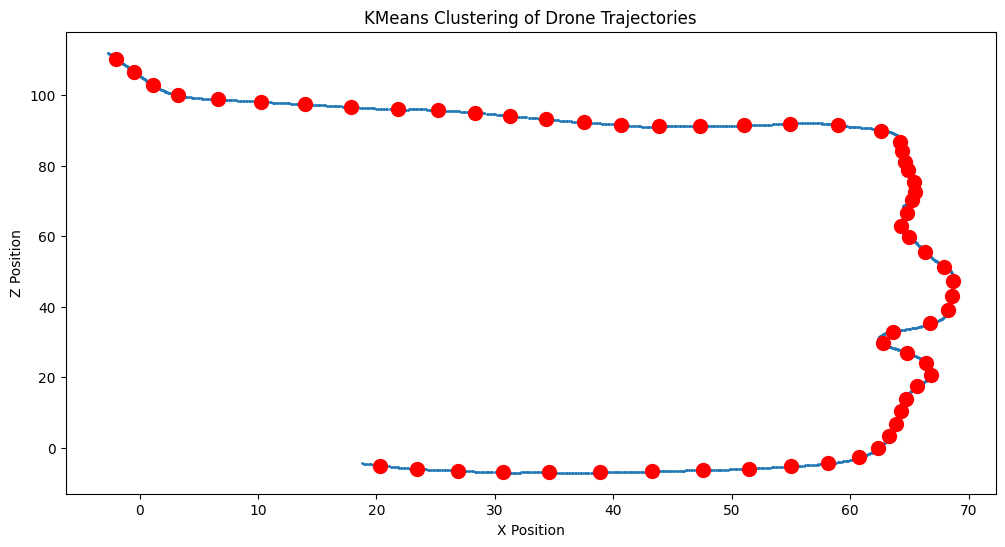

In [52]:
#plot tghe kmeans
plt.figure(figsize=(12, 6))
plt.scatter(dfplot["meanPosX"], dfplot["meanPosZ"], s=1)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='red')
plt.title("KMeans Clustering of Drone Trajectories")
plt.xlabel("X Position")
plt.ylabel("Z Position")
plt.show()


In [53]:
#pickled dump the path
with open("path.pkl", "wb") as f:
    pickle.dump(path, f)

    

In [54]:
conditions = [["Obstacle", "TDV", "H"], ["Obstacle", "TDV", "NH"], ["Obstacle", "FPV", "H"], ["Obstacle", "FPV", "NH"], ["Collectibles", "TDV", "H"], ["Collectibles", "TDV", "NH"], ["Collectibles", "FPV", "H"], ["Collectibles", "FPV", "NH"]]

In [55]:
path = pickle.load(open("path.pkl", "rb"))

In [56]:
setProgress(dfFolders, path)

216 217 218 219 220 221 222 223 296 297 298 299 300 301 302 303 

In [ ]:
#for index, df in dfFolders.iterrows():

dfFolders["IsolationDetails"] = None

for index, _ in dfFolders.iterrows():
    dfFolders.at[index,"IsolationDetailsNumber"] = 0
    dfFolders.at[index,"IsolationDetailsTime"] = 0
    dfFolders.at[index,"IsolationTimeMean"] = 0
    
    dfFolders.at[index, "Study"]["isIsolated"] = 0
    dfFolders.at[index, "Study"]["isIsolated"] = (dfFolders.at[index, "Study"]["isolation"].astype(int) != 0).astype(int)
    indices = dfFolders.at[index, "Study"]["isIsolated"].diff().loc[lambda x: x.abs() == 1]
    if(indices.empty):
        continue
    if(len(indices) % 2 != 0):
        #trow error
        print("Error")
        

    allData = []
    for i in range(0, len(indices), 2):
        start = indices.index[i]
        end = indices.index[i+1]
        length = end - start
        timeLength = dfFolders.at[index, "Study"].loc[end]["Time"] - dfFolders.at[index, "Study"].loc[start]["Time"]
        allData.append([start, end, length, timeLength])

    #make a dataframe
    dfIsolation = pd.DataFrame(allData, columns=["Start", "End", "Length", "TimeLength"])
    dfFolders.at[index,"IsolationDetails"] = dfIsolation

    if(len(dfIsolation) > 1):
        dfFolders.at[index,"IsolationDetailsNumber"] = len(dfIsolation)
        dfFolders.at[index,"IsolationDetailsTime"] = dfIsolation["TimeLength"].sum()
        dfFolders.at[index,"IsolationTimeMean"] = dfIsolation["TimeLength"].mean()
    else:
        dfFolders.at[index,"IsolationDetailsNumber"] = 0
        dfFolders.at[index,"IsolationDetailsTime"] = 0
        dfFolders.at[index,"IsolationTimeMean"] = 0


## Selection

In [ ]:
for index, df in dfFolders.iterrows():
    dfFolders.at[index, "NumberOfCrash"] = len(df["Crash"])


In [ ]:
conditions = [["Obstacle", "TDV", "H"], ["Obstacle", "FPV", "H"], ["Collectibles", "TDV", "H"], ["Collectibles", "FPV", "H"]]

allSelected = []

for condition in conditions:
    obstacle = condition[0]
    view = condition[1]

    dfT = dfFolders.query(f"Obstacle == '{obstacle}' & View == '{view}'")

    thresholdCrash = int(np.ceil(dfT["NumberOfCrash"].mean() + 2 * dfT["NumberOfCrash"].std()))
    thresholdTime = int(np.ceil(dfT["FinalTime"].mean() + 2 * dfT["FinalTime"].std()))
  #  thresholdIsolation = int(np.ceil(dfT["IsolationTimeMean"].mean() + 2 * dfT["IsolationTimeMean"].std()))

    #remove the outliers from the dfFolders
    dfTSelected = dfT.copy()
    dfTSelected = dfTSelected[dfTSelected["NumberOfCrash"] < thresholdCrash]
    dfTSelected = dfTSelected[dfTSelected["FinalTime"] < thresholdTime]
  #  dfTSelected = dfTSelected[dfTSelected["IsolationTimeMean"] < thresholdIsolation]
    allSelected.append(dfTSelected)

    

    print(f"Threshold for {obstacle}-{view} is {thresholdCrash} before {len(dfT)} after {len(dfTSelected)}")

dfFolders = pd.concat(allSelected)

Threshold for Obstacle-TDV is 2 before 80 after 71
Threshold for Obstacle-FPV is 6 before 80 after 72
Threshold for Collectibles-TDV is 2 before 80 after 71
Threshold for Collectibles-FPV is 8 before 80 after 73


In [ ]:
dfFolders = pd.read_pickle("dfFoldersFinal.pkl")

## COncat

In [57]:
#concatenate the dataframes

dfConcat = dfFolders.copy()

dfConcat = pd.concat([dfConcat, dfFoldersReal])


In [58]:
dfConcat.reset_index(drop=True, inplace=True)

In [60]:
dfConcat.to_pickle("dfFolders.pkl")

In [61]:
dfQuestionnaire = setQuestionnaire(dfConcat)

0 : 1436
1 : 179
PID not found for 4509
3 : 7160
4 : 3201
5 : 709
6 : 7216
7 : 9274
8 : 4014
PID not found for nan
10 : 6523
11 : 197
12 : 125
13 : 5134
14 : 6158
15 : 8313
16 : 9384
17 : 4730
18 : 1698
19 : 1548
20 : 2867
21 : 7409
22 : 3528
PID not found for 623
24 : 9355
25 : 3731
PID not found for 2106
27 : 8997
PID not found for 2097
29 : 6281
30 : 8670
31 : 9044
32 : 3623
33 : 9602
34 : 5250
35 : 3424
36 : 1241
37 : 9618
38 : 9227
39 : 7618
40 : 9027
41 : 4830
PID not found for 165
43 : 7648
PID not found for 348
PID not found for 9206
46 : 9569
47 : 813
35 35
PID not found for 4509
PID not found for nan
PID not found for 623
PID not found for 2106
PID not found for 2097
PID not found for 165
PID not found for 348
PID not found for 9206


In [62]:
dfConcat.to_pickle("dfFolders.pkl")
dfQuestionnaire.to_pickle("dfQuestionnaire.pkl")